In [1]:
# 필요한 라이브러리 설치
!pip install nibabel matplotlib

Data shape: (181, 217, 181)


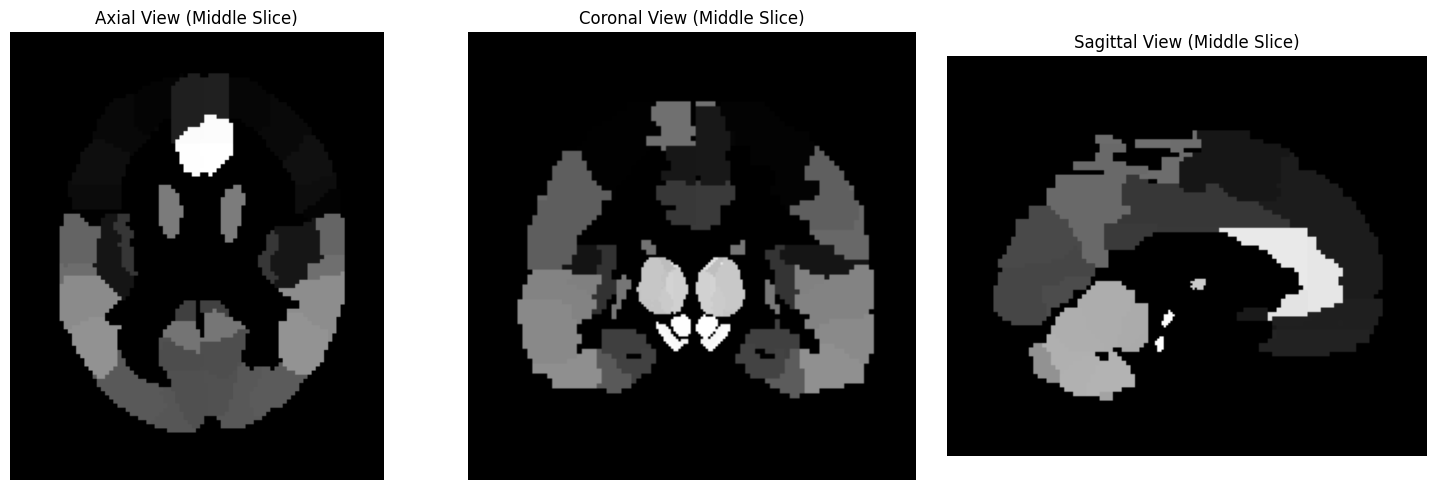

In [ ]:
# 라이브러리 임포트
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 파일 경로 지정
file_path = 'AFFIN/AAL3v1_1mm.nii'  # 코랩 환경에서 파일 업로드 후 경로를 지정하세요.

# NIfTI 파일 로드
img = nib.load(file_path)
data = img.get_fdata()

# 데이터 형태 출력
print(f"Data shape: {data.shape}")

# 중간 슬라이스 선택
mid_slice_axial = data[:, :, data.shape[2] // 2]
mid_slice_coronal = data[:, data.shape[1] // 2, :]
mid_slice_sagittal = data[data.shape[0] // 2, :, :]

# 시각화
plt.figure(figsize=(15, 5))

# Axial View
plt.subplot(1, 3, 1)
plt.imshow(mid_slice_axial.T, cmap="gray", origin="lower")
plt.title("Axial View (Middle Slice)")
plt.axis("off")

# Coronal View
plt.subplot(1, 3, 2)
plt.imshow(mid_slice_coronal.T, cmap="gray", origin="lower")
plt.title("Coronal View (Middle Slice)")
plt.axis("off")

# Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(mid_slice_sagittal.T, cmap="gray", origin="lower")
plt.title("Sagittal View (Middle Slice)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "monai/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 이진 형태로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    
    # 예측 결과를 이진 마스크로 변환 (0 또는 1)
    pred_mask = (prediction_array > 0.5).astype(np.float32)
    
    # nii 파일로 저장 (3D 형태로)
    mask_img = nib.Nifti1Image(pred_mask, t1_img.affine, t1_img.header)
    nib.save(mask_img, output_path)
    print(f"예측 마스크가 {output_path}에 저장되었습니다.")
    
    # 시각화 (선택적)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.title('Original FLAIR')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00033_flair.nii"]
    },
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/msk/SwinUnetR/predictions/00033" 
os.makedirs(output_dir, exist_ok=True) 

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join(output_dir, f"prediction_mask_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_mask_"):
        print(f"- {file}")

In [ ]:
#마스크를 오버레이한 3D NIFTI 이미지를 저장하고 싶다면 하단의 코드를 실행#

from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "monai/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 오버레이하여 nii 파일로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    t1_data = t1_img.get_fdata()
    
    # 차원 확인 및 조정
    if prediction_array.shape != t1_data.shape:
        raise ValueError(f"예측 마스크 shape {prediction_array.shape}가 FLAIR 이미지 shape {t1_data.shape}와 일치하지 않습니다.")
    
    # 시각화를 위해 T1 이미지 정규화 (0-1 범위로)
    t1_norm = (t1_data - t1_data.min()) / (t1_data.max() - t1_data.min())
    
    # RGB 이미지 생성 (4D: x, y, z, RGB)
    overlay = np.zeros((*t1_data.shape, 4))  # RGBA 이것때문에 처음에 아핀변환 후 AAL이 안되었었음
    
    # T1 이미지를 회색조로 설정
    overlay[..., 0] = t1_norm  # R
    overlay[..., 1] = t1_norm  # G
    overlay[..., 2] = t1_norm  # B
    overlay[..., 3] = 1.0      # A (완전 불투명)
    
    # 예측된 부분을 빨간색으로 오버레이
    mask = prediction_array > 0.5  # 이진 마스크로 변환
    overlay[mask, 0] = 1.0  # R (빨간색)
    overlay[mask, 1] = 0.0  # G
    overlay[mask, 2] = 0.0  # B
    overlay[mask, 3] = 1.0  # A
    
    # 특정 슬라이스 시각화 (디버깅용)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_norm[:, :, slice_idx], cmap='gray')
        plt.title('Original T1')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(overlay[:, :, slice_idx, :3])  # RGB만 표시
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # nii 파일로 저장
    overlay_img = nib.Nifti1Image(overlay, t1_img.affine, t1_img.header)
    nib.save(overlay_img, output_path)
    print(f"오버레이 이미지가 {output_path}에 저장되었습니다.")

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/msk/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00033_flair.nii"]
    },
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/msk/SwinUnetR/predictions/00033"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join(output_dir, f"prediction_flair_overlay_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_flair_overlay_"):
        print(f"- {file}")

In [ ]:
# 라이브러리 임포트
import nibabel as nib

# 파일 경로 지정
file_path = 'monai/predictions/flair_masks/prediction_mask_00033.nii.gz'  # 코랩 환경에서 파일 업로드 후 경로를 지정하세요.

# NIfTI 파일 로드
img = nib.load(file_path)
data = img.get_fdata()

# 데이터 형태 출력
print(f"Data shape: {data.shape}")

Data shape: (240, 240, 155)


In [ ]:
#!pip install nibabel nilearn matplotlib


In [ ]:
#!pip install SimpleITK


In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# 파일 로드
fixed_image_path = 'SwinUnetR/00033/Original images/BraTS2021_00033_t2.nii.gz'
moving_image_path = 'AFFIN/AAL3v1_1mm.nii'
prediction_output_path = 'SwinUnetR/00033/masks/prediction_mask_t2_00033.nii.gz'

fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
prediction_image = sitk.ReadImage(prediction_output_path, sitk.sitkFloat32)

# 정렬 객체 설정
registration_method = sitk.ImageRegistrationMethod()

# Similarity Metric 설정 (Normalized Mutual Information 사용)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Optimizer 설정
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Transform 초기값 설정
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Multi-resolution 방식 적용
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# 정렬 수행
final_transform = registration_method.Execute(fixed_image, moving_image)

# 이동 이미지 변환 (AAL 데이터 리샘플링)
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkNearestNeighbor,  # 마스크 데이터이므로 Nearest Neighbor 사용
    0.0,
    moving_image.GetPixelID()
)

# NumPy 배열로 변환
fixed_np = sitk.GetArrayFromImage(fixed_image)
moving_np = sitk.GetArrayFromImage(moving_resampled)
prediction_np = sitk.GetArrayFromImage(prediction_image)


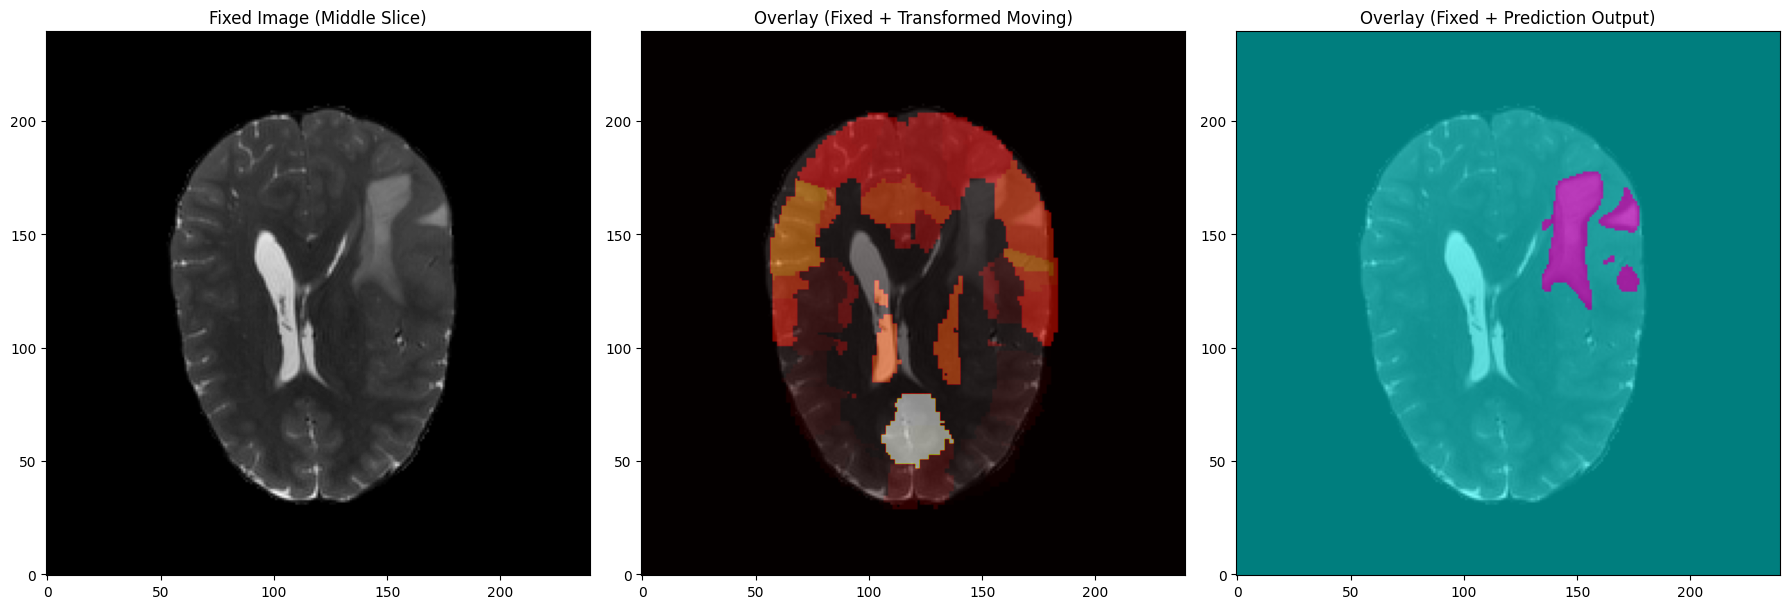

겹치는 voxel 수: 122467
겹치는 voxel 위치 (최대 10개 표시): 
[[ 19 105 152]
 [ 19 105 153]
 [ 19 105 154]
 [ 19 106 152]
 [ 19 106 153]
 [ 19 106 154]
 [ 19 107 153]
 [ 19 107 154]
 [ 19 108 153]
 [ 19 108 154]]
겹치는 마스크 번호: [  1.   7.   9.  11.  13.  17.  23.  29.  33.  39.  41.  43.  45.  47.
  49.  51.  53.  55.  57.  59.  61.  67.  69.  71.  75.  77.  79.  83.
  85.  87.  89.  91.  93.  99. 101. 114. 123. 125. 127. 129. 131. 139.
 141. 143. 145. 147. 149. 157. 161. 163.]
마스크 번호별 겹치는 voxel 수: {1.0: 6, 7.0: 965, 9.0: 201, 11.0: 233, 13.0: 3972, 17.0: 249, 23.0: 10, 29.0: 861, 33.0: 8474, 39.0: 79, 41.0: 5952, 43.0: 4740, 45.0: 1502, 47.0: 1875, 49.0: 47, 51.0: 2933, 53.0: 78, 55.0: 2489, 57.0: 2546, 59.0: 8136, 61.0: 558, 67.0: 1016, 69.0: 745, 71.0: 912, 75.0: 111, 77.0: 5751, 79.0: 1829, 83.0: 1512, 85.0: 12788, 87.0: 5609, 89.0: 26209, 91.0: 2369, 93.0: 13267, 99.0: 5, 101.0: 151, 114.0: 25, 123.0: 20, 125.0: 312, 127.0: 1055, 129.0: 1105, 131.0: 11, 139.0: 268, 141.0: 98, 143.0: 235, 145.0: 741

In [19]:
# 중간 슬라이스 시각화
slice_index_x = fixed_np.shape[0] // 2
slice_index_y = fixed_np.shape[1] // 2
slice_index_z = fixed_np.shape[2] // 2

#slice_index = 140
fixed_slice = fixed_np[slice_index_x, :, :]
moving_slice = moving_np[slice_index_x, :, :]
prediction_slice = prediction_np[slice_index_x, :, :]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Fixed Image (Middle Slice)")
plt.imshow(fixed_slice, cmap='gray', origin='lower')

plt.subplot(1, 3, 2)
plt.title("Overlay (Fixed + Transformed Moving)")
plt.imshow(fixed_slice, cmap='gray', origin='lower')
plt.imshow(moving_slice, cmap='hot', alpha=0.5, origin='lower')

plt.subplot(1, 3, 3)
plt.title("Overlay (Fixed + Prediction Output)")
plt.imshow(fixed_slice, cmap='gray', origin='lower')
plt.imshow(prediction_slice, cmap='cool', alpha=0.5, origin='lower')

plt.tight_layout()
plt.show()

# 겹치는 부분 계산
aal_np = sitk.GetArrayFromImage(moving_resampled)
prediction_np = sitk.GetArrayFromImage(prediction_image)

overlap_mask = (aal_np > 0) & (prediction_np > 0)
overlap_indices = np.argwhere(overlap_mask)
overlap_labels = aal_np[overlap_mask]
unique_labels = np.unique(overlap_labels)  # 겹치는 마스크 번호

# 결과 출력
print(f"겹치는 voxel 수: {len(overlap_indices)}")
print(f"겹치는 voxel 위치 (최대 10개 표시): \n{overlap_indices[:10]}")
print(f"겹치는 마스크 번호: {unique_labels}")

# 마스크 번호별 겹치는 voxel 수 계산
label_counts = {label: np.sum(overlap_labels == label) for label in unique_labels}
print(f"마스크 번호별 겹치는 voxel 수: {label_counts}")

# 겹치는 영역 저장
overlap_image = sitk.GetImageFromArray(overlap_mask.astype(np.uint8))
overlap_image.CopyInformation(fixed_image)
sitk.WriteImage(overlap_image, "overlap_mask.nii")
print("겹치는 부분은 overlap_mask.nii로 저장되었습니다.")


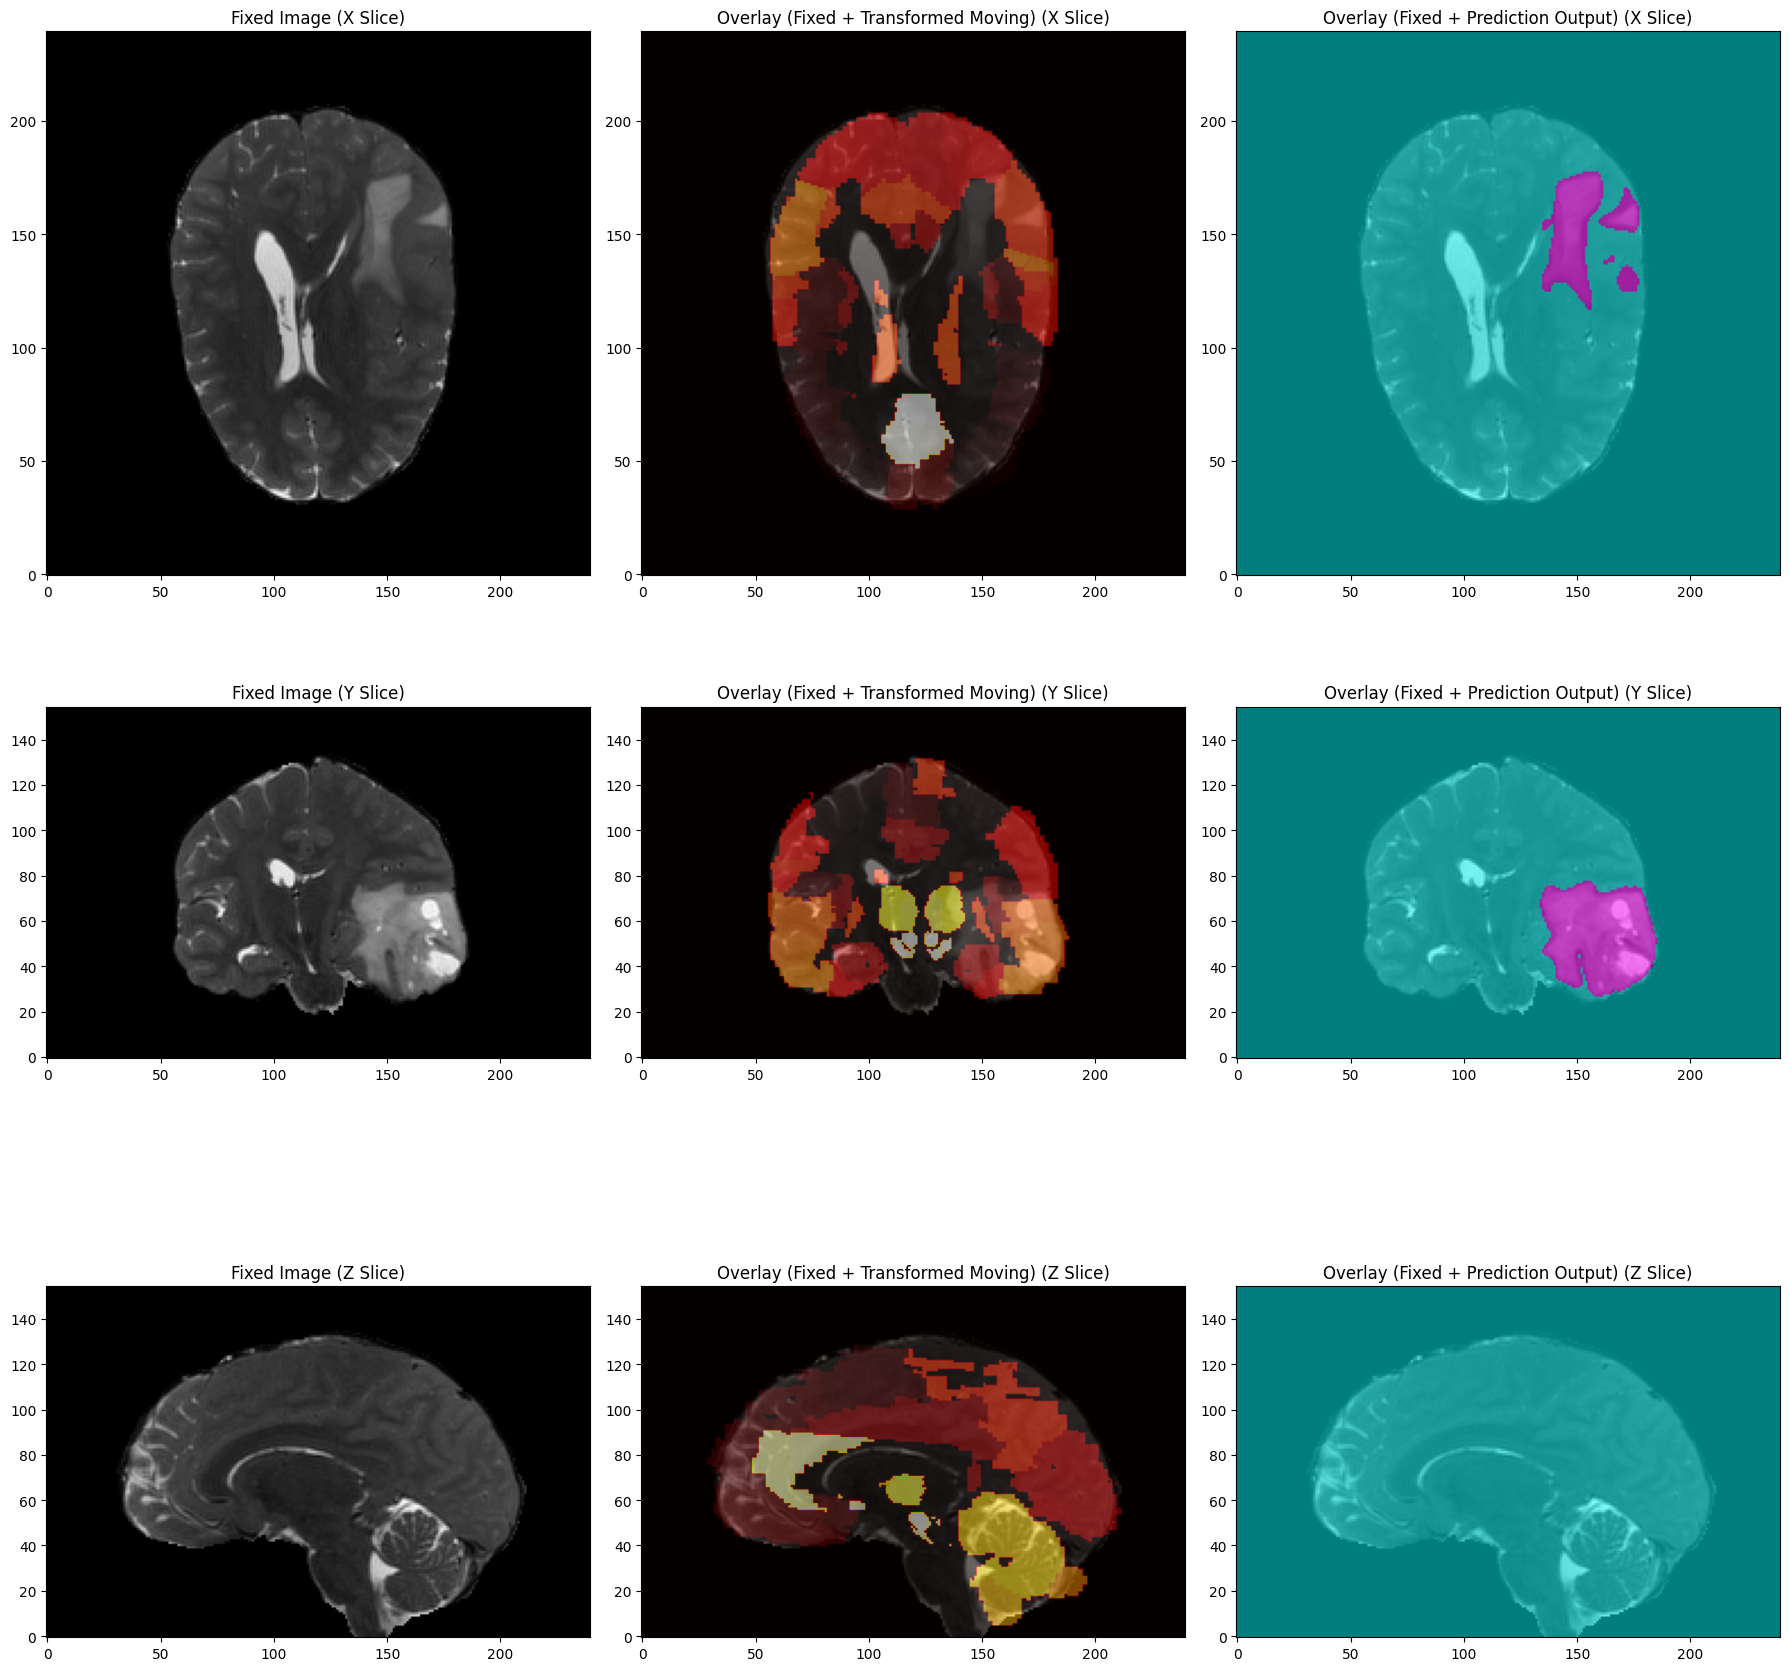

겹치는 voxel 수: 122467
겹치는 voxel 위치 (최대 10개 표시): 
[[ 19 105 152]
 [ 19 105 153]
 [ 19 105 154]
 [ 19 106 152]
 [ 19 106 153]
 [ 19 106 154]
 [ 19 107 153]
 [ 19 107 154]
 [ 19 108 153]
 [ 19 108 154]]
겹치는 마스크 번호: [  1.   7.   9.  11.  13.  17.  23.  29.  33.  39.  41.  43.  45.  47.
  49.  51.  53.  55.  57.  59.  61.  67.  69.  71.  75.  77.  79.  83.
  85.  87.  89.  91.  93.  99. 101. 114. 123. 125. 127. 129. 131. 139.
 141. 143. 145. 147. 149. 157. 161. 163.]
마스크 번호별 겹치는 voxel 수: {1.0: 6, 7.0: 965, 9.0: 201, 11.0: 233, 13.0: 3972, 17.0: 249, 23.0: 10, 29.0: 861, 33.0: 8474, 39.0: 79, 41.0: 5952, 43.0: 4740, 45.0: 1502, 47.0: 1875, 49.0: 47, 51.0: 2933, 53.0: 78, 55.0: 2489, 57.0: 2546, 59.0: 8136, 61.0: 558, 67.0: 1016, 69.0: 745, 71.0: 912, 75.0: 111, 77.0: 5751, 79.0: 1829, 83.0: 1512, 85.0: 12788, 87.0: 5609, 89.0: 26209, 91.0: 2369, 93.0: 13267, 99.0: 5, 101.0: 151, 114.0: 25, 123.0: 20, 125.0: 312, 127.0: 1055, 129.0: 1105, 131.0: 11, 139.0: 268, 141.0: 98, 143.0: 235, 145.0: 741

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

# 중간 슬라이스 시각화
slice_index_x = fixed_np.shape[0] // 2
slice_index_y = fixed_np.shape[1] // 2
slice_index_z = fixed_np.shape[2] // 2

# 각 축의 슬라이스 추출
fixed_slice_x = fixed_np[slice_index_x, :, :]
moving_slice_x = moving_np[slice_index_x, :, :]
prediction_slice_x = prediction_np[slice_index_x, :, :]

fixed_slice_y = fixed_np[:, slice_index_y, :]
moving_slice_y = moving_np[:, slice_index_y, :]
prediction_slice_y = prediction_np[:, slice_index_y, :]

fixed_slice_z = fixed_np[:, :, slice_index_z]
moving_slice_z = moving_np[:, :, slice_index_z]
prediction_slice_z = prediction_np[:, :, slice_index_z]

# 시각화
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# X축 시각화
axes[0, 0].set_title("Fixed Image (X Slice)")
axes[0, 0].imshow(fixed_slice_x, cmap='gray', origin='lower')
axes[0, 1].set_title("Overlay (Fixed + Transformed Moving) (X Slice)")
axes[0, 1].imshow(fixed_slice_x, cmap='gray', origin='lower')
axes[0, 1].imshow(moving_slice_x, cmap='hot', alpha=0.5, origin='lower')
axes[0, 2].set_title("Overlay (Fixed + Prediction Output) (X Slice)")
axes[0, 2].imshow(fixed_slice_x, cmap='gray', origin='lower')
axes[0, 2].imshow(prediction_slice_x, cmap='cool', alpha=0.5, origin='lower')

# Y축 시각화
axes[1, 0].set_title("Fixed Image (Y Slice)")
axes[1, 0].imshow(fixed_slice_y, cmap='gray', origin='lower')
axes[1, 1].set_title("Overlay (Fixed + Transformed Moving) (Y Slice)")
axes[1, 1].imshow(fixed_slice_y, cmap='gray', origin='lower')
axes[1, 1].imshow(moving_slice_y, cmap='hot', alpha=0.5, origin='lower')
axes[1, 2].set_title("Overlay (Fixed + Prediction Output) (Y Slice)")
axes[1, 2].imshow(fixed_slice_y, cmap='gray', origin='lower')
axes[1, 2].imshow(prediction_slice_y, cmap='cool', alpha=0.5, origin='lower')

# Z축 시각화
axes[2, 0].set_title("Fixed Image (Z Slice)")
axes[2, 0].imshow(fixed_slice_z, cmap='gray', origin='lower')
axes[2, 1].set_title("Overlay (Fixed + Transformed Moving) (Z Slice)")
axes[2, 1].imshow(fixed_slice_z, cmap='gray', origin='lower')
axes[2, 1].imshow(moving_slice_z, cmap='hot', alpha=0.5, origin='lower')
axes[2, 2].set_title("Overlay (Fixed + Prediction Output) (Z Slice)")
axes[2, 2].imshow(fixed_slice_z, cmap='gray', origin='lower')
axes[2, 2].imshow(prediction_slice_z, cmap='cool', alpha=0.5, origin='lower')

plt.tight_layout()
plt.show()

# 겹치는 부분 계산
aal_np = sitk.GetArrayFromImage(moving_resampled)
prediction_np = sitk.GetArrayFromImage(prediction_image)

overlap_mask = (aal_np > 0) & (prediction_np > 0)
overlap_indices = np.argwhere(overlap_mask)
overlap_labels = aal_np[overlap_mask]
unique_labels = np.unique(overlap_labels)  # 겹치는 마스크 번호

# 결과 출력
print(f"겹치는 voxel 수: {len(overlap_indices)}")
print(f"겹치는 voxel 위치 (최대 10개 표시): \n{overlap_indices[:10]}")
print(f"겹치는 마스크 번호: {unique_labels}")

# 마스크 번호별 겹치는 voxel 수 계산
label_counts = {label: np.sum(overlap_labels == label) for label in unique_labels}
print(f"마스크 번호별 겹치는 voxel 수: {label_counts}")

# 겹치는 영역 저장
overlap_image = sitk.GetImageFromArray(overlap_mask.astype(np.uint8))
overlap_image.CopyInformation(fixed_image)
sitk.WriteImage(overlap_image, "overlap_3axis_mask.nii")
print("겹치는 부분은 overlap_mask.nii로 저장되었습니다.")


In [ ]:
import numpy as np

# AAL3 텍스트 파일 읽기
label_mapping = {}
with open("AFFIN/AAL3v1_1mm.nii.txt", "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        label_id = int(parts[0])
        label_name = " ".join(parts[1:])
        label_mapping[label_id] = label_name

# 겹치는 마스크 번호 출력
print(f"겹치는 마스크 번호: {unique_labels}")

# 레이블 번호를 이름으로 변환하여 출력
print("겹치는 마스크 번호(이름으로):")
for label in unique_labels:
    label_name = label_mapping.get(label, "Unknown")  # 라벨 이름이 없으면 "Unknown"
    print(f"레이블 {label}: {label_name}")

# 마스크 번호별 겹치는 voxel 수 계산 및 출력
label_counts = {label: np.sum(overlap_labels == label) for label in unique_labels}
print(f"마스크 번호별 겹치는 voxel 수:")
for label, count in label_counts.items():
    label_name = label_mapping.get(label, "Unknown")  # 라벨 이름이 없으면 "Unknown"
    print(f"{label_name}: {count} Voxel")


겹치는 마스크 번호: [  1.   7.   9.  11.  13.  17.  23.  29.  33.  39.  41.  43.  45.  47.
  49.  51.  53.  55.  57.  59.  61.  67.  69.  71.  75.  77.  79.  83.
  85.  87.  89.  91.  93.  99. 101. 114. 123. 125. 127. 129. 131. 139.
 141. 143. 145. 147. 149. 157. 161. 163.]
겹치는 마스크 번호(이름으로):
레이블 1.0: Precentral_L 1
레이블 7.0: Frontal_Inf_Oper_L 7
레이블 9.0: Frontal_Inf_Tri_L 9
레이블 11.0: Frontal_Inf_Orb_2_L 11
레이블 13.0: Rolandic_Oper_L 13
레이블 17.0: Olfactory_L 17
레이블 23.0: Rectus_L 23
레이블 29.0: OFCpost_L 29
레이블 33.0: Insula_L 33
레이블 39.0: Cingulate_Post_L 39
레이블 41.0: Hippocampus_L 41
레이블 43.0: ParaHippocampal_L 43
레이블 45.0: Amygdala_L 45
레이블 47.0: Calcarine_L 47
레이블 49.0: Cuneus_L 49
레이블 51.0: Lingual_L 51
레이블 53.0: Occipital_Sup_L 53
레이블 55.0: Occipital_Mid_L 55
레이블 57.0: Occipital_Inf_L 57
레이블 59.0: Fusiform_L 59
레이블 61.0: Postcentral_L 61
레이블 67.0: SupraMarginal_L 67
레이블 69.0: Angular_L 69
레이블 71.0: Precuneus_L 71
레이블 75.0: Caudate_L 75
레이블 77.0: Putamen_L 77
레이블 79.0: Pallidum_L 79
레이블 83.0: H

In [22]:
# Predict output의 양성 voxel 수 계산
total_prediction_voxels = np.sum(prediction_np > 0)

# Fixed image의 양성 voxel 수 계산
total_fixed_voxels = np.sum(fixed_np > 0)

# Predict output이 Fixed image 대비 몇 퍼센트인지 계산
if total_fixed_voxels > 0:
    predict_vs_fixed_ratio = total_prediction_voxels / total_fixed_voxels * 100
else:
    predict_vs_fixed_ratio = 0

# Fixed image의 voxel 크기 확인 (spacing)
spacing = fixed_image.GetSpacing()  # x, y, z 방향 크기 (단위: mm)
voxel_volume_mm3 = spacing[0] * spacing[1] * spacing[2]  # voxel의 부피 (mm³)

# 양성 voxel의 총 부피 (mm³) -> m³로 변환
total_fixed_volume_m3 = total_fixed_voxels * voxel_volume_mm3 * 1e-9  # mm³ -> m³로 변환

# 결과 출력
print(f"Predict output의 양성 voxel 수 (size): {total_prediction_voxels}")
print(f"Fixed image의 양성 voxel 수 (size): {total_fixed_voxels}")
print(f"Predict output이 Fixed image 대비 {predict_vs_fixed_ratio:.2f}% 크기를 가집니다.")
print(f"Fixed image의 양성 voxel 총 부피: {total_fixed_volume_m3:.6f} m³")

Predict output의 양성 voxel 수 (size): 163170
Fixed image의 양성 voxel 수 (size): 1504645
Predict output이 Fixed image 대비 10.84% 크기를 가집니다.
Fixed image의 양성 voxel 총 부피: 0.001505 m³


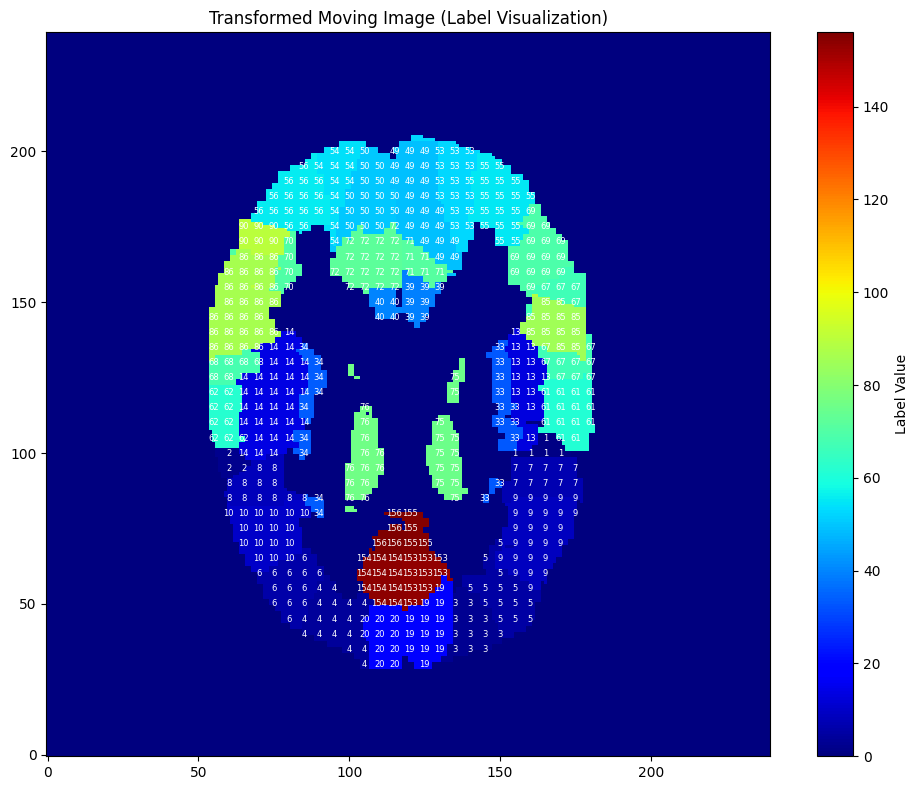

In [44]:
# 중간 슬라이스 시각화 (라벨 숫자 표시)
plt.figure(figsize=(10, 8))
plt.title("Transformed Moving Image (Label Visualization)")
plt.imshow(moving_slice, cmap='jet', origin='lower')  # 'jet' colormap 사용

# 픽셀 값(라벨) 표시
for i in range(0, moving_slice.shape[0], 5):  # 세로 방향 간격 5로 조정
    for j in range(0, moving_slice.shape[1], 5):  # 가로 방향 간격 5로 조정
        label = int(moving_slice[i, j])
        if label > 0:  # 라벨이 0보다 큰 경우만 표시
            plt.text(j, i, str(label), color="white", fontsize=6, ha='center', va='center')

plt.colorbar(label="Label Value")
plt.tight_layout()
plt.show()


In [45]:
np.unique(moving_slice)


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        13.,  14.,  19.,  20.,  33.,  34.,  39.,  40.,  49.,  50.,  53.,
        54.,  55.,  56.,  61.,  62.,  67.,  68.,  69.,  70.,  71.,  72.,
        75.,  76.,  85.,  86.,  89.,  90., 153., 154., 155., 156.],
      dtype=float32)

In [46]:
np.unique(moving_np)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
        92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102.,
       103., 104., 105., 106., 107., 108., 109., 110., 111., 112., 113.,
       114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
       125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146.,
       147., 148., 149., 150., 151., 152., 153., 15